In [1]:
import os
import re
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
plt.style.use('seaborn-v0_8-paper')

In [2]:
with open('./results/greaterthan_absval_pruned_heads.json', 'r') as f:
    pruned_heads = json.load(f)
with open('./results/greaterthan_absval_num_passes.json', 'r') as f:
    num_passes = json.load(f)

In [3]:
cleaned_heads = {}

for thresh in pruned_heads.keys():
    cleaned_heads[thresh] = {}
    cleaned_heads[thresh]['acdcpp'] = set()
    cleaned_heads[thresh]['acdc'] = set()

    for i in range(2):
        for head in pruned_heads[thresh][i]:
            attn_head_pttn = re.compile('^<a([0-9]+)\.([0-9]+)>$')
            matched = attn_head_pttn.match(head)
            if matched:
                head_str = f'{matched.group(1)}.{matched.group(2)}'
                if i == 0:
                    cleaned_heads[thresh]['acdcpp'].add(head_str)
                else:
                    cleaned_heads[thresh]['acdc'].add(head_str)
    

In [4]:
true_baseline_heads = set(["5.1", "5.5", "6.1", "6.9", "7.10", "8.8", "8.11", "9.1"])
print(len(true_baseline_heads))

all_heads = set()

for layer in range(12):
    for head in range(12):
        all_heads.add(f'{layer}.{head}')

8


In [5]:
data = {
    'Threshold': [0],
    'ACDCpp TPR': [1],
    'ACDCpp TNR': [0],
    'ACDCpp FPR': [1],
    'ACDCpp FNR': [0],
    'TPR': [1],
    'TNR': [0],
    'FPR': [1],
    'FNR': [0],
    'Num Passes': [np.inf],
}

for thresh in cleaned_heads.keys():
    data['Threshold'].append(round(float(thresh), 3)) # Correct rounding error
    # Variables prefixed with pp_ are after ADCDCpp only
    pp_heads = cleaned_heads[thresh]['acdcpp']
    heads = cleaned_heads[thresh]['acdc']
    
    pp_tp = len(pp_heads.intersection(true_baseline_heads))
    pp_tn = len((all_heads - true_baseline_heads).intersection(all_heads - pp_heads))
    pp_fp = len(pp_heads - true_baseline_heads)
    pp_fn = len(true_baseline_heads - pp_heads)

    tp = len(heads.intersection(true_baseline_heads))
    tn = len((all_heads - true_baseline_heads).intersection(all_heads - heads))
    fp = len(heads - true_baseline_heads)
    fn = len(true_baseline_heads - heads)

    pp_tpr = pp_tp / (pp_tp + pp_fn)
    pp_tnr = pp_tn / (pp_tn + pp_fp)
    pp_fpr = 1 - pp_tnr
    pp_fnr = 1 - pp_tpr

    tpr = tp / (tp + fn)
    tnr = tn / (tn + fp)
    fpr = 1 - tnr
    fnr = 1 - tpr

    data['ACDCpp TPR'].append(pp_tpr)
    data['ACDCpp TNR'].append(pp_tnr)
    data['ACDCpp FPR'].append(pp_fpr)
    data['ACDCpp FNR'].append(pp_fnr)

    data['TPR'].append(tpr)
    data['TNR'].append(tnr)
    data['FPR'].append(fpr)
    data['FNR'].append(fnr)

    data['Num Passes'].append(num_passes[thresh])
df = pd.DataFrame(data)
# Add thresh inf to end of df
row = [np.inf, 0, 1, 0, 1, 0, 1, 0, 1, 0]
df.loc[len(df)] = row

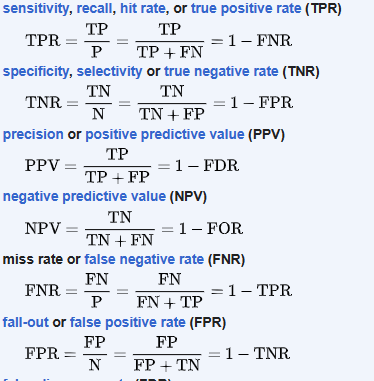

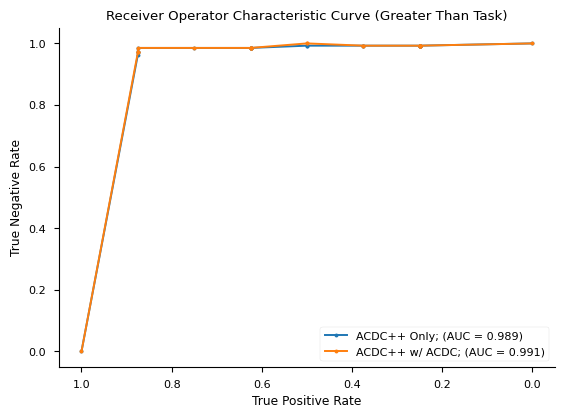

In [21]:
# Calculate AUC using trapezoidal rule
auc = round(np.sum(np.array(df['TPR'])[:-1] * np.diff(np.array(df['TNR']))),3)
pp_auc = round(np.sum(np.array(df['ACDCpp TPR'])[:-1] * np.diff(np.array(df['ACDCpp TNR']))),3)

plt.plot(df['ACDCpp TPR'], df['ACDCpp TNR'], marker='.', label=f'ACDC++ Only; (AUC = {pp_auc})')
plt.plot(df['TPR'], df['TNR'], marker='.', label=f'ACDC++ w/ ACDC; (AUC = {auc})')
plt.xlabel('True Positive Rate')
plt.ylabel('True Negative Rate')
plt.title('Receiver Operator Characteristic Curve (Greater Than Task)')
plt.legend()
plt.gca().invert_xaxis()

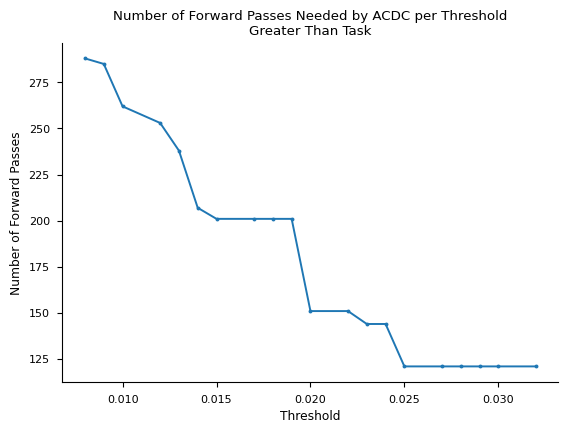

In [22]:
plt.plot(df['Threshold'], df['Num Passes'], marker='.')
plt.xlabel('Threshold')
plt.ylabel('Number of Forward Passes')
plt.title('Number of Forward Passes Needed by ACDC per Threshold\nGreater Than Task')
plt.show()